# 401k Maximizer: Adaptive Contribution Strategy

This notebook simulates a strategy to maximize 401k growth by dynamically adjusting S&P 500 (SPY) contributions based on market conditions. The goal is to invest more when SPY is relatively low and less when it is high, while always meeting the annual IRS contribution limit. Contributions are made every 2 weeks, and the strategy can use statistical, RL, or active inference methods.


In [51]:
# --- Setup: Input Variables and Constants ---
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# User inputs
age = 29
current_year = datetime.today().year

# IRS 401k annual contribution limit (2025, update as needed)
max_yearly_contribution = 23000  # 2024 IRS limit, update for future years
min_contribution_percent = 0.02
max_contribution_percent = 0.50
company_match_percent = 0.06
min_contribution_percent = company_match_percent if company_match_percent > min_contribution_percent else min_contribution_percent
z_threshold_low = -1.5  # Z-score threshold for low contributions
z_threshold_high = 0.5  # Z-score threshold for high contributions

# Portfolio (can expand later)
portfolio = {'sp500': 'SPY'}

# Paycheck frequency and periods
pay_periods_per_year = 26  # biweekly

# Calculate per-period max/min contributions
min_period_contribution = min_contribution_percent * max_yearly_contribution / pay_periods_per_year
max_period_contribution = max_contribution_percent * max_yearly_contribution / pay_periods_per_year

print(f"Biweekly min contribution: ${min_period_contribution:.2f}")
print(f"Biweekly max contribution: ${max_period_contribution:.2f}")


Biweekly min contribution: $53.08
Biweekly max contribution: $442.31


In [52]:
# --- Set matplotlib to dark mode for all plots ---
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['figure.facecolor'] = '#181818'
plt.rcParams['axes.edgecolor'] = '#444444'
plt.rcParams['axes.labelcolor'] = '#cccccc'
plt.rcParams['xtick.color'] = '#cccccc'
plt.rcParams['ytick.color'] = '#cccccc'
plt.rcParams['text.color'] = '#cccccc'
plt.rcParams['legend.facecolor'] = '#222222'
plt.rcParams['legend.edgecolor'] = '#444444'
plt.rcParams['grid.color'] = '#333333'
plt.rcParams['axes.grid'] = True


In [53]:
# --- Download SPY Historical Data and Resample to Biweekly ---
spy = yf.download('SPY', start='1995-12-22', end=datetime.today().strftime('%Y-%m-%d'), progress=False)
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = spy.columns.get_level_values(0)

spy = spy[['Close']].dropna()

# Resample to biweekly (every 2 weeks, using Friday close if possible)
spy_biweekly = spy.resample('2W-FRI').last().dropna()
spy_biweekly['Return'] = spy_biweekly['Close'].pct_change()
spy_biweekly['Z_Score'] = (spy_biweekly['Close'] - spy_biweekly['Close'].rolling(52).mean()) / spy_biweekly['Close'].rolling(52).std()

print(f"SPY biweekly periods: {len(spy_biweekly)}")
spy_biweekly.tail()

SPY biweekly periods: 772


C:\Users\saris\AppData\Local\Temp\ipykernel_36704\4197534890.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='1995-12-22', end=datetime.today().strftime('%Y-%m-%d'), progress=False)


Price,Close,Return,Z_Score
Date,,,
2025-05-16,592.448547,0.048416,1.330064
2025-05-30,587.652771,-0.008095,1.209938
2025-06-13,595.240295,0.012912,1.286424
2025-06-27,614.909973,0.033045,1.546384
2025-07-11,620.450012,0.009010,1.569830


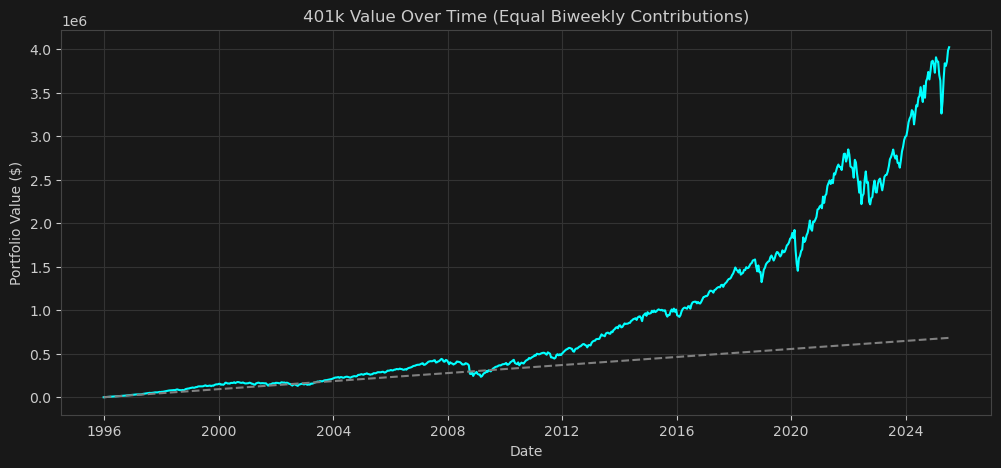

Total contributed: 682923.08
Number of shares: 6481.92
Total value: 4021707.36


In [58]:

# --- Baseline Strategy: Equal Biweekly Contributions ---
def simulate_equal_contributions(df, yearly_contribution, pay_periods_per_year):
    df = df.copy()
    period_contribution = yearly_contribution / pay_periods_per_year
    shares = []
    total_shares = 0

    for price in df['Close'].values:
        if pd.isna(price):
            shares.append(total_shares)
            continue
        buy_shares = period_contribution / price
        total_shares += buy_shares
        shares.append(total_shares)

    df['Equal_Contrib_Shares'] = shares
    df['Equal_Contrib_Value'] = df['Equal_Contrib_Shares'] * df['Close']
    df['Total_Contributed'] = np.arange(1, len(df) + 1) * period_contribution
    return df

spy_biweekly = simulate_equal_contributions(spy_biweekly, max_yearly_contribution, pay_periods_per_year)


# --- Plot the results ---
plt.figure(figsize=(12, 5))
plt.plot(spy_biweekly.index, spy_biweekly['Equal_Contrib_Value'], label='401k Value (Equal Contrib)', color='cyan')
plt.plot(spy_biweekly.index, spy_biweekly['Total_Contributed'], label='Total Contributed', color='gray', linestyle='--')
plt.title('401k Value Over Time (Equal Biweekly Contributions)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()

# add twodecimal place only for the last row
print('Total contributed:', spy_biweekly['Total_Contributed'].iloc[-1].round(2))
print('Number of shares:', spy_biweekly['Equal_Contrib_Shares'].iloc[-1].round(2))
print('Total value:', spy_biweekly['Equal_Contrib_Value'].iloc[-1].round(2))

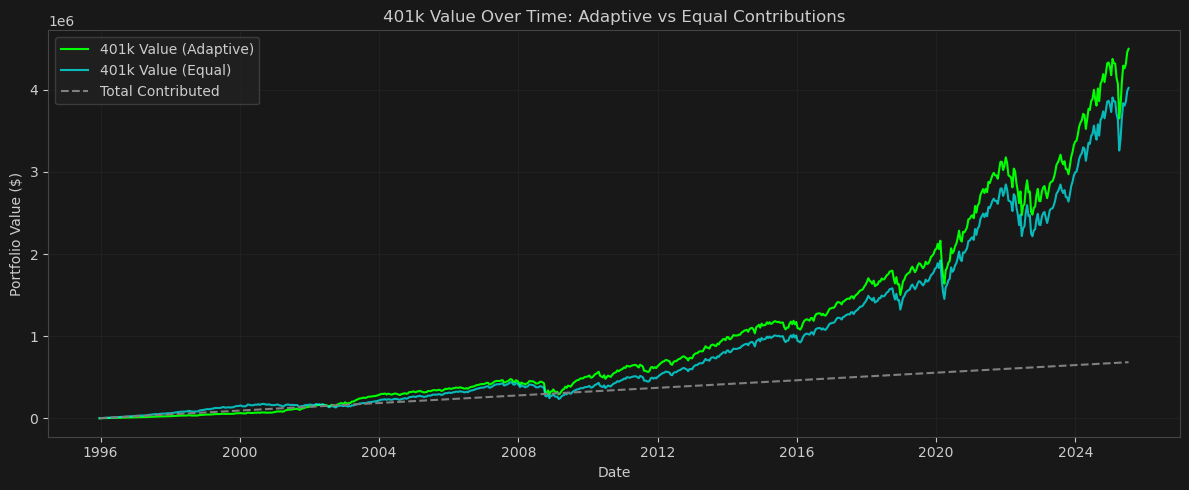

In [59]:
# --- Adaptive Contribution Strategy: Z-Score Based ---
def simulate_adaptive_contributions(spy_biweekly, max_yearly_contribution, pay_periods_per_year, min_percent, max_percent, z_low_thresh=-.5, z_high_thresh=0.5):
    periods = len(spy_biweekly)
    yearly_contribution = max_yearly_contribution
    min_contrib = min_percent * yearly_contribution / pay_periods_per_year
    max_contrib = max_percent * yearly_contribution / pay_periods_per_year
    contribs = []
    total_contrib = 0
    for i, (date, row) in enumerate(spy_biweekly.iterrows()):
        z = row['Z_Score']
        # If z-score is low (SPY is low), contribute more; if high, contribute less
        if np.isnan(z):
            contrib = min_contrib
        elif z < z_low_thresh:
            contrib = max_contrib
        elif z > z_high_thresh:
            contrib = min_contrib
        else:
            # Linear interpolate between min and max
            contrib = min_contrib + (max_contrib - min_contrib) * (0.5 - z) / 1.0
            contrib = np.clip(contrib, min_contrib, max_contrib)
        contribs.append(contrib)
        total_contrib += contrib
    # Scale all contributions to exactly match the annual max
    scale = (yearly_contribution * (periods // pay_periods_per_year)) / sum(contribs)
    contribs = [c * scale for c in contribs]
    shares = []
    total_shares = 0
    for i, (date, row) in enumerate(spy_biweekly.iterrows()):
        price = row['Close']
        buy_shares = contribs[i] / price if price > 0 else 0
        total_shares += buy_shares
        shares.append(total_shares)
    spy_biweekly['Adaptive_Contrib'] = contribs
    spy_biweekly['Adaptive_Shares'] = shares
    spy_biweekly['Adaptive_Value'] = spy_biweekly['Adaptive_Shares'] * spy_biweekly['Close']
    return spy_biweekly

spy_biweekly = simulate_adaptive_contributions(spy_biweekly, max_yearly_contribution, pay_periods_per_year, min_contribution_percent, max_contribution_percent, z_threshold_low, z_threshold_high)

plt.figure(figsize=(12,5))
plt.plot(spy_biweekly.index, spy_biweekly['Adaptive_Value'], label='401k Value (Adaptive)', color='lime')
plt.plot(spy_biweekly.index, spy_biweekly['Equal_Contrib_Value'], label='401k Value (Equal)', color='cyan', alpha=0.7)
plt.plot(spy_biweekly.index, spy_biweekly['Total_Contributed'], label='Total Contributed', color='gray', linestyle='--')
plt.title('401k Value Over Time: Adaptive vs Equal Contributions')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [60]:
# --- Results Comparison and Summary ---
final_equal = spy_biweekly['Equal_Contrib_Value'].iloc[-1]
final_adaptive = spy_biweekly['Adaptive_Value'].iloc[-1]
total_contributed = spy_biweekly['Total_Contributed'].iloc[-1]
print(f"Final 401k Value (Equal Contributions): ${final_equal:,.2f}")
print(f"Final 401k Value (Adaptive Contributions): ${final_adaptive:,.2f}")
print(f"Total Contributed: ${total_contributed:,.2f}")
print(f"Adaptive minus Equal: ${final_adaptive - final_equal:,.2f}")

# Show average and std of contributions per period
print("\nContribution stats (per period):")
print("Equal: $%.2f" % (max_yearly_contribution / pay_periods_per_year))
print("Adaptive: mean $%.2f, std $%.2f" % (spy_biweekly['Adaptive_Contrib'].mean(), spy_biweekly['Adaptive_Contrib'].std()))


Final 401k Value (Equal Contributions): $4,021,707.36
Final 401k Value (Adaptive Contributions): $4,498,750.77
Total Contributed: $682,923.08
Adaptive minus Equal: $477,043.41

Contribution stats (per period):
Equal: $884.62
Adaptive: mean $863.99, std $978.28


In [61]:
# --- Parameter Search: Find Optimal Adaptive Contribution Parameters ---
from itertools import product

# Parameter grid
max_contrib_grid = np.arange(0.10, max_contribution_percent + .01, 0.05)  # 10% to 50%
min_contrib_grid = np.arange(min_contribution_percent, 0.16, 0.02)  # 2% to 15%
z_low_grid = np.arange(-2.5, 0.0, 0.25)         # -1.5 to 0
z_high_grid = np.arange(0.0, 2.6, 0.25 )        # 0 to 1.5

best_val = -np.inf
best_params = None
results = []

for max_c, min_c, z_low, z_high in product(max_contrib_grid, min_contrib_grid, z_low_grid, z_high_grid):
    if min_c >= max_c:
        continue
    # Custom adaptive simulation with variable thresholds
    def simulate_custom_adaptive(df, max_yearly_contribution, pay_periods_per_year, min_percent, max_percent, z_low, z_high):
        periods = len(df)
        min_contrib = min_percent * max_yearly_contribution / pay_periods_per_year
        max_contrib = max_percent * max_yearly_contribution / pay_periods_per_year
        contribs = []
        for i, (date, row) in enumerate(df.iterrows()):
            z = row['Z_Score']
            if np.isnan(z):
                contrib = min_contrib
            elif z < z_low:
                contrib = max_contrib
            elif z > z_high:
                contrib = min_contrib
            else:
                # Linear interpolate between min and max
                contrib = min_contrib + (max_contrib - min_contrib) * (z_high - z) / (z_high - z_low)
                contrib = np.clip(contrib, min_contrib, max_contrib)
            contribs.append(contrib)
        # Scale to match annual max
        scale = (max_yearly_contribution * (periods // pay_periods_per_year)) / sum(contribs)
        contribs = [c * scale for c in contribs]
        shares = []
        total_shares = 0
        for i, (date, row) in enumerate(df.iterrows()):
            price = row['Close']
            buy_shares = contribs[i] / price if price > 0 else 0
            total_shares += buy_shares
            shares.append(total_shares)
        value = shares[-1] * df['Close'].iloc[-1]
        return value
    val = simulate_custom_adaptive(
        spy_biweekly, max_yearly_contribution, pay_periods_per_year, min_c, max_c, z_low, z_high)
    results.append((val, max_c, min_c, z_low, z_high))
    if val > best_val:
        best_val = val
        best_params = (max_c, min_c, z_low, z_high)

print(f"Best final 401k value: ${best_val:,.2f}")
print(f"Best params: max_contrib={best_params[0]:.2f}, min_contrib={best_params[1]:.2f}, z_low={best_params[2]:.2f}, z_high={best_params[3]:.2f}")


Best final 401k value: $4,669,056.82
Best params: max_contrib=0.50, min_contrib=0.06, z_low=-1.50, z_high=0.00
